[![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/multiple-schemas.ipynb) [![在 LangChain Academy 中打开](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239434-lesson-3-multiple-schemas)


# 多种 Schema

## 回顾

我们刚刚学习了状态 schema 和 reducer。

通常，所有图节点都会使用同一个 schema 进行通信。

这个单一的 schema 也包含了图的输入和输出键 / 通道。

## 目标

不过，有些场景下我们可能希望拥有更多控制力：

* 内部节点可能会传递一些对图的输入 / 输出来说并不需要的信息。
* 我们也可能希望为图设置不同的输入 / 输出 schema。例如输出只包含一个最相关的键。

接下来我们会讨论如何通过多种 schema 来定制图。


In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## 私有状态

首先，我们来看一下在节点之间传递[私有状态](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/)的情形。

这对于图在中间处理逻辑时需要但又与整体输入或输出无关的信息非常有用。

我们会定义一个 `OverallState` 和一个 `PrivateState`。

`node_2` 读取 `PrivateState` 作为输入，但会写入 `OverallState`。


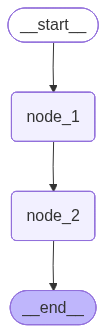

In [ ]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


class OverallState(TypedDict):
    foo: int


class PrivateState(TypedDict):
    baz: int


def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": state["foo"] + 1}


def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"foo": state["baz"] + 1}


# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"foo": 1})

---Node 1---
---Node 2---


{'foo': 3}

`baz` 只存在于 `PrivateState` 中。

`node_2` 读取 `PrivateState` 作为输入，但会写入 `OverallState`。

因此可以看到，`baz` 不在图的输出中，因为它不属于 `OverallState`。


## 输入 / 输出 Schema

默认情况下，`StateGraph` 只接受一个 schema，所有节点都应使用该 schema 进行通信。

不过，我们也可以[为图显式地定义输入和输出 schema](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp)。

这种情况下，我们通常会定义一个包含图运作所需全部键的“内部” schema。

然后使用特定的 `input` 和 `output` schema 来约束实际的输入与输出。

先用单一 schema 跑一次图。


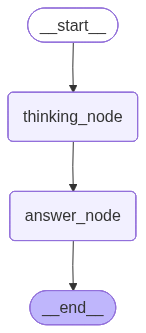

In [4]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str


def thinking_node(state: OverallState):
    return {"answer": "bye", "notes": "... his name is Lance"}


def answer_node(state: OverallState):
    return {"answer": "bye Lance"}


graph = StateGraph(OverallState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

可以看到，`invoke` 的输出包含了 `OverallState` 中的全部键。


In [5]:
graph.invoke({"question": "hi"})

{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his name is Lance'}

现在，我们给图设置特定的 `input` 和 `output` schema。

此时，`input` / `output` schema 会对图允许的输入和输出键进行*筛选*。

此外，我们可以在各节点中通过类型提示 `state: InputState` 来声明该节点使用的输入 schema。

当图使用多个 schema 时，这会很重要。

下面的类型提示可以帮我们看出，`answer_node` 的输出会被过滤为 `OutputState`。


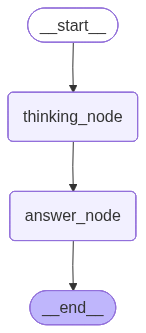

{'answer': 'bye Lance'}

In [6]:
class InputState(TypedDict):
    question: str


class OutputState(TypedDict):
    answer: str


class OverallState(TypedDict):
    question: str
    answer: str
    notes: str


def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name is Lance"}


def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}


graph = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question": "hi"})

可以看到，`output` schema 将输出限制为只有 `answer` 键。
